# Visão computacional - MFCC

## Impor bibliotecas 

In [1]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import os.path

## Lendo audio salvos na pasta 'samples' 

In [19]:
SAMPLE_DIR = 'samples/'
files = next(os.walk(SAMPLE_DIR))[2]
files = list(files)
files

['s22_i6.wav',
 's15_i6.wav',
 's17_i10.wav',
 's35_i3.wav',
 's19_i2.wav',
 's19_i1.wav',
 's35_i10.wav',
 's39_i4.wav',
 's25_i4.wav',
 's6_i9.wav',
 's17_i3.wav',
 's31_i1.wav',
 's21_i1.wav',
 's7_i9.wav',
 's32_i3.wav',
 's8_i2.wav',
 's36_i5.wav',
 's42_i7.wav',
 's7_i6.wav',
 's29_i8.wav',
 's23_i3.wav',
 's34_i3.wav',
 's33_i2.wav',
 's42_i8.wav',
 's18_i3.wav',
 's20_i9.wav',
 's1_i6.wav',
 's2_i7.wav',
 's9_i9.wav',
 's22_i7.wav',
 's15_i3.wav',
 's12_i10.wav',
 's34_i9.wav',
 's18_i7.wav',
 's9_i6.wav',
 's41_i1.wav',
 's33_i7.wav',
 's42_i9.wav',
 's38_i5.wav',
 's3_i7.wav',
 's35_i5.wav',
 's39_i1.wav',
 's34_i2.wav',
 's10_i9.wav',
 's34_i8.wav',
 's24_i4.wav',
 's9_i8.wav',
 's12_i8.wav',
 's33_i5.wav',
 's24_i7.wav',
 's21_i6.wav',
 's33_i6.wav',
 's29_i5.wav',
 's20_i2.wav',
 's3_i4.wav',
 's6_i6.wav',
 's39_i10.wav',
 's29_i1.wav',
 's10_i7.wav',
 's20_i4.wav',
 's36_i10.wav',
 's12_i1.wav',
 's22_i4.wav',
 's28_i10.wav',
 's8_i3.wav',
 's8_i10.wav',
 's35_i2.wav',
 '

## Lendo audio com scipy

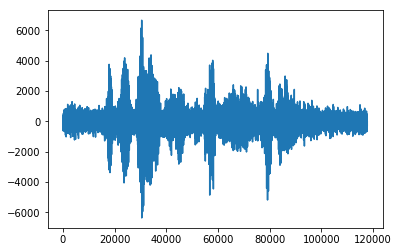

32000

In [3]:
rate, signal = scipy.io.wavfile.read(SAMPLE_DIR + files[0])
signal_len = len(signal)
plt.plot(signal)
plt.show()
rate

## Escolhemos o tamanho do frame de 0.2 e passo de 0.1

In [4]:
frame_size = (20 / 1000) * rate
frame_advance = (10 / 1000) * rate

frame_size = int(round(frame_size))
frame_advance = int(round(frame_advance))

frame_size, frame_advance

(640, 320)

## Quantidade de frames do audio

In [5]:
num_frames = int(np.ceil(float(np.abs(signal_len - frame_size)) / frame_advance))
num_frames

366

## Realizamos o pandding (adição de zeros no sinal) para arredonda a quantidade de frames

In [6]:
pad_signal_length = num_frames * frame_advance + frame_size
z = np.zeros((int(pad_signal_length) - signal_len))
pad_signal = np.append(signal, z)
pad_signal, z

(array([ 252.,  240.,  229., ..., -243., -140.,  -29.]),
 array([], dtype=float64))

## Exibindo a janela de hamming

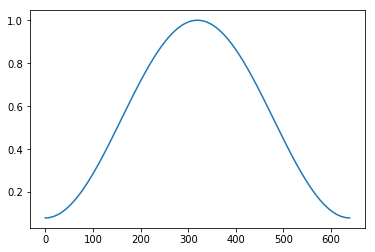

In [7]:
plt.plot(np.hamming(frame_size))
plt.show()

## Aplicamos a janela sobre o cada frame da imagem

In [8]:
indices = np.tile(np.arange(0, frame_size), (num_frames, 1)) + np.tile(
    np.arange(0, num_frames * frame_advance, frame_advance), (frame_size, 1)).T
frames = pad_signal[indices.astype(np.int32, copy=False)]
frames *= np.hamming(frame_size)
frames

array([[ 20.16      ,  19.20533696,  18.34036889, ..., -33.07673516,
        -29.52820557, -24.4       ],
       [-26.96      , -26.8074495 , -22.34481624, ...,  57.50386403,
         59.53654456,  55.84      ],
       [-22.8       , -27.4476274 , -32.67629042, ...,  22.98552782,
         25.60711594,  27.92      ],
       ..., 
       [ 15.36      ,   9.92275743,   0.88097842, ..., -26.58953044,
        -27.28758292, -23.92      ],
       [-26.64      , -25.20700475, -20.02223678, ...,  32.91655726,
         36.33009574,  33.6       ],
       [-24.96      , -34.0894731 , -39.24358408, ...,  42.04669723,
         44.97249737,  44.        ]])

# Gerando banco de filtos

## Definindo valores padrões -> Num de filtros, samples da nfft e quantidade de ceptrais

In [9]:
nfft = 2048
cep = 12
num_filters = 40

## Vamos gerar os filtros de frequência de acordo com o trabalho sugerido por Sanderson

In [10]:
sanderson_filters = np.array([200, 300, 400, 500, 600, 700, 800, 900, 1000, 1149, 1320, 1516, 1741, 2000, 2297, 2639, 3031, 3482, 4000])


## Vamos listar apenas as frequências centrais (200hz é a freq inicial e 4000 é a final)

In [11]:
central_freqs = sanderson_filters[1:-1] # Remove o inicial e final, mantendo apenas os centrais
central_freqs

array([ 300,  400,  500,  600,  700,  800,  900, 1000, 1149, 1320, 1516,
       1741, 2000, 2297, 2639, 3031, 3482])

## Calcular onde começa e termina cada filtro

In [12]:
nfilt = len(central_freqs)
bin = np.floor((nfft + 1) * sanderson_filters / rate)
bin

array([  12.,   19.,   25.,   32.,   38.,   44.,   51.,   57.,   64.,
         73.,   84.,   97.,  111.,  128.,  147.,  168.,  194.,  222.,  256.])

## Calcular banco de filtros

In [13]:
fbank = np.zeros((nfilt, int(np.floor(nfft / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])  # inicial
    f_m = int(bin[m])  # central
    f_m_plus = int(bin[m + 1])  # final

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])


## Desenhando os filtros

/home/alano/.virtualenvs/visao_computacional/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  """Entry point for launching an IPython kernel.


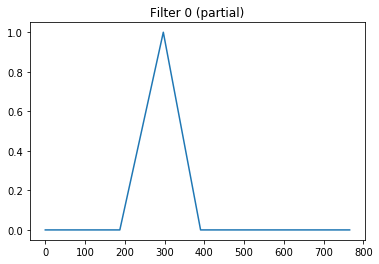

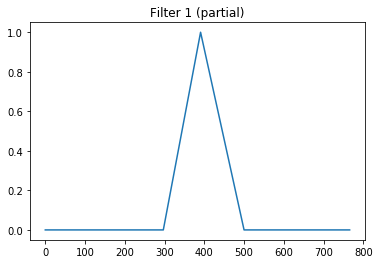

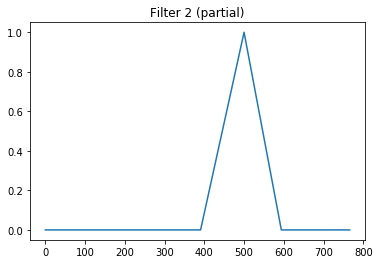

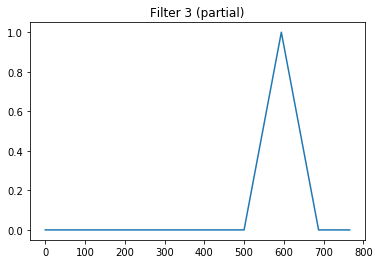

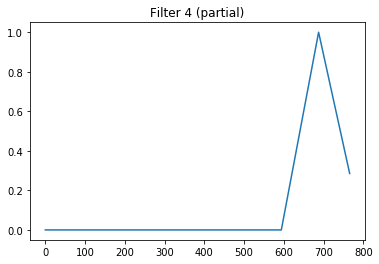

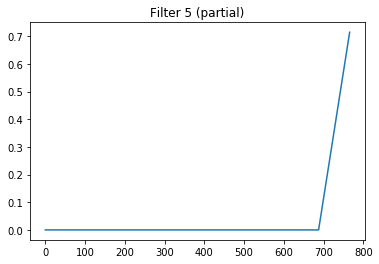

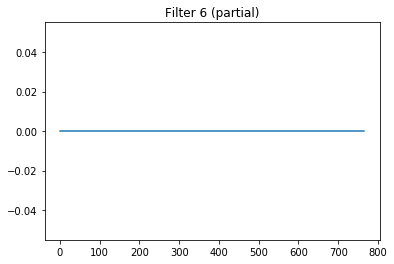

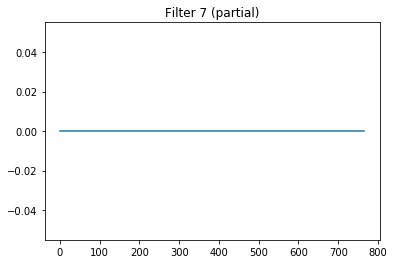

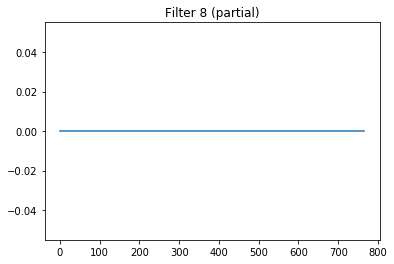

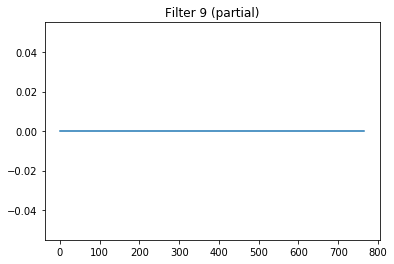

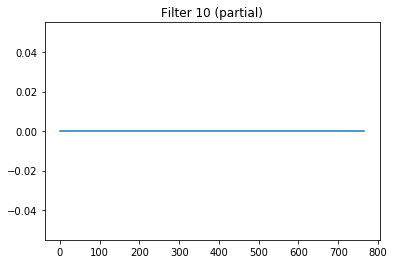

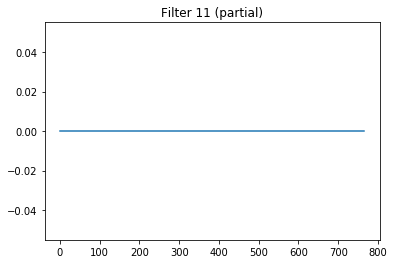

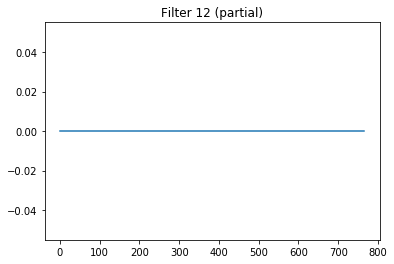

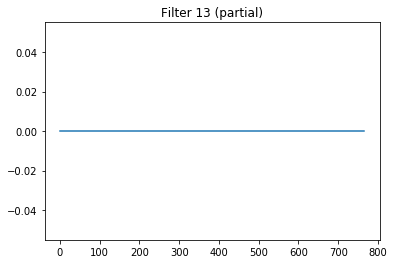

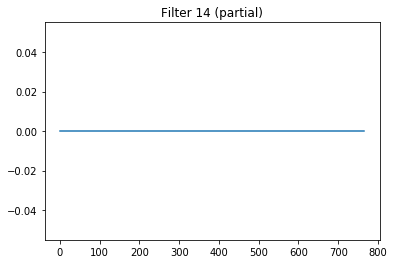

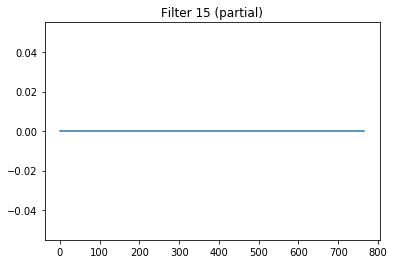

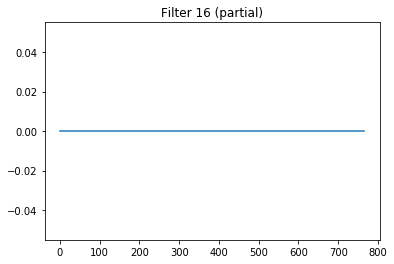

In [14]:
f = np.linspace(0, rate / 2, np.ceil((nfft + 1) / 2))
for idx in range(0, len(fbank)):
    plt.figure(idx)
    plt.title('Filter %d (partial)' % idx)
    plt.plot(f[0:50], fbank[idx][0:50])
plt.show()

## Fourier do sinal

/home/alano/.virtualenvs/visao_computacional/lib/python3.5/site-packages/ipykernel_launcher.py:4: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  after removing the cwd from sys.path.


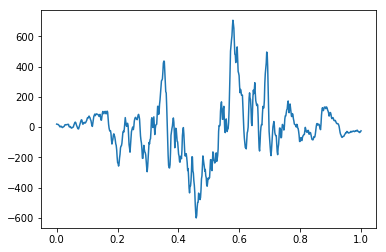

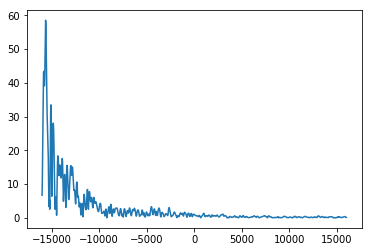

In [15]:
frame = frames[0]
Ws = 0.020
Ns = Ws * rate
lin = np.linspace(0, 1, Ns)
plt.plot(lin, frame)
plt.show()
Y = np.fft.fft(frame, nfft) / len(frame)
Z = abs(Y)
NUP = int(np.ceil((len(Y) + 1) / 2))
Z = Z[0:NUP]
f = rate * np.linspace(-0.5, 0.5, NUP)
plt.plot(f, Z)
plt.show()

In [16]:
Y = np.fft.rfft(frames, nfft)
Z = abs(Y)
NUP = int(np.ceil((len(Y) + 1) / 2))
Z = Z[0:NUP]

pow_frames = ((1.0 / nfft) * ((Z) ** 2))


## Aplicando filtros

In [17]:
filters = fbank
filter_banks = np.dot(pow_frames, filters.T)
# Estabilizar
filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
signal_filtered = np.log10(filter_banks)
signal_filtered

array([[ 6.01430373,  5.48458148,  5.8111494 , ...,  5.10596245,
         4.7283634 ,  4.48835517],
       [ 6.2703864 ,  6.39048102,  5.84674814, ...,  5.00739446,
         4.83891416,  4.68832732],
       [ 5.84163954,  6.65593507,  6.61482917, ...,  5.10651236,
         5.02922802,  4.47081899],
       ..., 
       [ 7.35876886,  8.16260409,  8.18593967, ...,  5.94190638,
         6.2275801 ,  5.17727672],
       [ 7.00399529,  7.56906585,  7.41204235, ...,  5.40095166,
         5.68920842,  5.027574  ],
       [ 7.29976912,  7.40878725,  6.8778495 , ...,  5.06983271,
         5.37075528,  4.63000556]])

## Calculando o MFCC

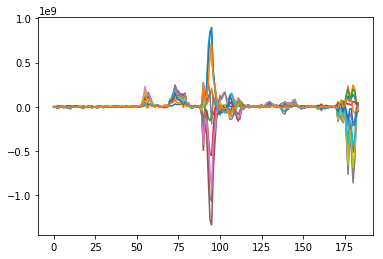

array([[  7.10767700e+05,   4.26477170e+05,   1.62479871e+06, ...,
          3.47054024e+06,   2.04676128e+06,   1.97658684e+06],
       [  1.98565006e+06,   3.29483061e+06,   3.55297833e+06, ...,
         -3.47934432e+06,  -5.55522964e+06,  -6.12251914e+06],
       [  3.21780981e+06,   5.64391745e+06,   5.48041832e+06, ...,
         -1.18435126e+07,  -7.32878376e+06,  -4.17072924e+06],
       ..., 
       [  1.10096977e+08,   2.05712584e+08,   1.77643837e+08, ...,
         -3.61932896e+08,  -2.02149671e+08,  -7.17116377e+07],
       [  2.40797311e+07,   4.88738329e+07,   5.13558799e+07, ...,
         -1.00252200e+08,  -6.95254696e+07,  -4.01787685e+07],
       [  1.91547932e+07,   3.74011923e+07,   4.33693794e+07, ...,
         -4.37494185e+07,  -4.53731754e+07,  -3.66550447e+07]])

In [32]:
cep_lifter = 17

mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1: (cep + 1)]  # Keep 2-13
(nframes, ncoeff) = mfcc.shape
n = np.arange(ncoeff)
lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
mfcc *= lift
plt.plot(mfcc)
plt.show()
mfcc

184


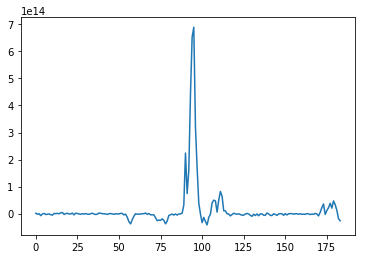

-3.2716863636124941e+23

In [37]:
from numpy.linalg import det
covariance = np.cov(mfcc)
print(len(mfcc))
plt.plot(covariance[0])
plt.show()
np.linalg.det(covariance)